In [1]:
from IPython.display import display
display(HTML("<style>.container { width:80% !important; }</style>"))

NameError: name 'HTML' is not defined

In [2]:
# Load experimental results from files.

from pathlib import Path
import re
import yaml
from yaml import SafeLoader

EXP_PATH = "/home/hazrael/GitRepositories/storalloc-gitlab/simulation/results/grid5000"
#RUN_NAME = "exp__29-Mar-22_16-54__no_retry"
EXP_NAME = ["full_param_space_01-Apr-22"]

exp_data = []

infra_pattern = re.compile(r"infra\d+TB")
system_pattern = re.compile(r"(single|multi)(_[a-z]+){3}")
algo_pattern = re.compile(r"split_(\d+[G|T][_retry]*)_(\S+)_infra\d+TB")

for name in EXP_NAME:
    exp_path = Path(f"{EXP_PATH}/{name}")
    result_files = exp_path.glob("*.yml")

    for file in result_files:
        with open(file, "r", encoding="utf-8") as yaml_file:
            exp = yaml.load(yaml_file, Loader=SafeLoader)
            exp["full_name"] = file.stem.split('__')[1]
            exp["infra"] = infra_pattern.findall(exp["full_name"])[0]
            exp["system"] = system_pattern.search(exp["full_name"])[0]
            algo_match = algo_pattern.search(exp['full_name'])
            exp["split_threshold_keyword"] = algo_match.groups()[0]
            exp["algo"] = algo_match.groups()[1]
            exp_data.append(exp)

In [3]:
# Load them (almost) unprocessed into a DataFrame

import pandas as pd

df_data = pd.DataFrame(exp_data)

rows, cols = df_data.shape
if rows != 192:
    raise ValueError("Something went wrong, there are less than 192 rows")

print(f"Number of columns : {cols}")
    
df_data

Number of columns : 22


,alloc_delayed_requests_count,alloc_split_requests_count,delayed_requests_count,max_concurrent_allocations,nodes,registrations_count,requests_count,retries_allowed,scheduler_fallbacks_count,sim_duration,...,split_requests_count,split_threshold_gb,tt_allocated_gb,tt_deallocated_gb,tt_delay_time_minutes,full_name,infra,system,split_threshold_keyword,algo
0,0,1029,0,239,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,39052,yes,379,31515560,...,1030,100,1.570556e+06,1.570556e+06,0.0,split_100G_retry_worst_fit_infra16TB_multi_nod...,infra16TB,multi_node_single_disk,100G_retry,worst_fit
1,0,0,0,182,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,24001,yes,277,31515560,...,0,100000,5.737175e+05,5.737175e+05,0.0,split_100T_retry_random_infra16TB_multi_node_m...,infra16TB,multi_node_multi_disk,100T_retry,random
2,266,1029,266,219,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,39052,yes,1679,31515560,...,1029,100,1.440344e+06,1.440344e+06,23544000.0,split_100G_retry_rr_infra16TB_multi_node_singl...,infra16TB,multi_node_single_disk,100G_retry,rr
3,0,0,0,181,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,24001,yes,464,31515560,...,0,100000,2.776835e+05,2.776835e+05,0.0,split_100T_retry_rr_infra8TB_multi_node_multi_...,infra8TB,multi_node_multi_disk,100T_retry,rr
4,0,0,0,181,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,24001,no,463,31515560,...,0,100000,2.778360e+05,2.778360e+05,0.0,split_100T_worst_fit_infra8TB_multi_node_multi...,infra8TB,multi_node_multi_disk,100T,worst_fit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0,1027,0,237,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,39052,yes,3101,31515560,...,1030,100,1.301248e+06,1.301248e+06,0.0,split_100G_retry_random_infra8TB_multi_node_mu...,infra8TB,multi_node_multi_disk,100G_retry,random
188,0,0,0,181,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,24001,yes,456,31515560,...,0,100000,2.811906e+05,2.811906e+05,0.0,split_100T_retry_worst_case_infra8TB_multi_nod...,infra8TB,multi_node_multi_disk,100T_retry,worst_case
189,0,0,0,183,"[{'disks': [{'capacity': 8000, 'id': 0, 'last_...",1,24001,no,70,31515560,...,0,100000,1.012041e+06,1.012041e+06,0.0,split_100T_worst_case_infra8TB_single_node_sin...,infra8TB,single_node_single_disk,100T,worst_case
190,0,968,0,219,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,39052,no,1739,31515560,...,968,100,1.437161e+06,1.437161e+06,0.0,split_100G_worst_case_infra16TB_single_node_mu...,infra16TB,single_node_multi_disk,100G,worst_case


In [4]:
# Compute some means (per node / disk) extracted from the "nodes" column 
# and add them as new columns in the original dataset

# New columns
mean_node_alloc = [] # extracted from existing field
max_node_alloc = []
mean_node_utilisation = []
max_node_utilisation = []


for idx, row in df_data.iterrows():

    acc_mean_node_alloc = []
    acc_max_disk_alloc = []
    acc_mean_cap_utilisation = []
    acc_max_cap_utilisation = []
    
    # print(row['nodes'])
    ## NODES
    for node in row["nodes"]:
        # print(node)
        
        acc_mean_node_alloc.append(node["mean_nb_alloc"])
        
        mean_disk_alloc = []
        mean_cap_utilisation = []

        # DISKS
        for disk in node["disks"]:
            # print(disk["max_alloc"])
            acc_max_disk_alloc.append(disk["max_alloc"])
            mean_disk_alloc.append(disk["mean_nb_alloc"])
            acc_max_cap_utilisation.append(disk["max_cap_utilisation"])
            mean_cap_utilisation.append(disk["mean_capacity_utilisation"])
        
        
        mean_disk_alloc = pd.Series(mean_disk_alloc).mean()
        acc_mean_cap_utilisation = pd.Series(mean_cap_utilisation).mean()
        
    
    # Building future column for DataFrame
    mean_node_alloc.append(pd.Series(acc_mean_node_alloc).mean())
    max_node_alloc.append(max(acc_max_disk_alloc))
    mean_node_utilisation.append(pd.Series(acc_mean_cap_utilisation).mean())
    max_node_utilisation.append(max(acc_max_cap_utilisation))
    
    
df_data["mean_node_alloc"] = mean_node_alloc
df_data["max_node_alloc"] = max_node_alloc
df_data["mean_node_utilisation"] = mean_node_utilisation
df_data["max_node_utilisation"] = max_node_utilisation
df_data
# df_data["split_threshold_gb"]

,alloc_delayed_requests_count,alloc_split_requests_count,delayed_requests_count,max_concurrent_allocations,nodes,registrations_count,requests_count,retries_allowed,scheduler_fallbacks_count,sim_duration,...,tt_delay_time_minutes,full_name,infra,system,split_threshold_keyword,algo,mean_node_alloc,max_node_alloc,mean_node_utilisation,max_node_utilisation
0,0,1029,0,239,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,39052,yes,379,31515560,...,0.0,split_100G_retry_worst_fit_infra16TB_multi_nod...,infra16TB,multi_node_single_disk,100G_retry,worst_fit,0.782625,171,2.615000,100.000
1,0,0,0,182,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,24001,yes,277,31515560,...,0.0,split_100T_retry_random_infra16TB_multi_node_m...,infra16TB,multi_node_multi_disk,100T_retry,random,0.714000,38,1.678000,98.953
2,266,1029,266,219,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,39052,yes,1679,31515560,...,23544000.0,split_100G_retry_rr_infra16TB_multi_node_singl...,infra16TB,multi_node_single_disk,100G_retry,rr,0.739750,38,2.207000,100.000
3,0,0,0,181,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,24001,yes,464,31515560,...,0.0,split_100T_retry_rr_infra8TB_multi_node_multi_...,infra8TB,multi_node_multi_disk,100T_retry,rr,0.670500,34,7.498000,99.524
4,0,0,0,181,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,24001,no,463,31515560,...,0.0,split_100T_worst_fit_infra8TB_multi_node_multi...,infra8TB,multi_node_multi_disk,100T,worst_fit,0.670000,158,1.031500,99.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0,1027,0,237,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,39052,yes,3101,31515560,...,0.0,split_100G_retry_random_infra8TB_multi_node_mu...,infra8TB,multi_node_multi_disk,100G_retry,random,1.523000,39,4.835000,100.000
188,0,0,0,181,"[{'disks': [{'capacity': 1000, 'id': 0, 'last_...",1,24001,yes,456,31515560,...,0.0,split_100T_retry_worst_case_infra8TB_multi_nod...,infra8TB,multi_node_multi_disk,100T_retry,worst_case,0.669500,23,1.191000,99.524
189,0,0,0,183,"[{'disks': [{'capacity': 8000, 'id': 0, 'last_...",1,24001,no,70,31515560,...,0.0,split_100T_worst_case_infra8TB_single_node_sin...,infra8TB,single_node_single_disk,100T,worst_case,2.874000,183,4.507000,99.986
190,0,968,0,219,"[{'disks': [{'capacity': 2000, 'id': 0, 'last_...",1,39052,no,1739,31515560,...,0.0,split_100G_worst_case_infra16TB_single_node_mu...,infra16TB,single_node_multi_disk,100G,worst_case,5.987000,28,2.537625,100.000


In [5]:
df_data.describe()

,alloc_delayed_requests_count,alloc_split_requests_count,delayed_requests_count,max_concurrent_allocations,registrations_count,requests_count,scheduler_fallbacks_count,sim_duration,sim_first_ts,sim_last_ts,split_requests_count,split_threshold_gb,tt_allocated_gb,tt_deallocated_gb,tt_delay_time_minutes,mean_node_alloc,max_node_alloc,mean_node_utilisation,max_node_utilisation
count,192.000000,192.000000,192.000000,192.000000,192.0,192.000000,192.000000,1.920000e+02,1.920000e+02,1.920000e+02,192.000000,192.000000,1.920000e+02,1.920000e+02,1.920000e+02,192.000000,192.000000,192.000000,192.000000
mean,19.822917,504.635417,19.822917,218.140625,1.0,31526.500000,891.067708,3.151554e+07,1.577931e+09,1.609447e+09,505.192708,50050.000000,1.134311e+06,1.134311e+06,1.723219e+06,2.650243,106.588542,2.420549,88.100125
std,68.709952,506.628237,68.709952,42.962373,0.0,7545.174543,1365.837350,2.602406e+02,0.000000e+00,2.602406e+02,507.205133,50080.588458,4.517164e+05,4.517164e+05,6.182670e+06,2.178064,88.328590,1.815448,21.117838
min,0.000000,0.000000,0.000000,181.000000,1.0,24001.000000,0.000000,3.151195e+07,1.577931e+09,1.609443e+09,0.000000,100.000000,2.517015e+05,2.517015e+05,0.000000e+00,0.333625,23.000000,0.366000,45.588000
25%,0.000000,0.000000,0.000000,182.750000,1.0,24001.000000,45.000000,3.151556e+07,1.577931e+09,1.609447e+09,0.000000,100.000000,9.192297e+05,9.192297e+05,0.000000e+00,0.723500,36.000000,0.793156,94.519000
50%,0.000000,452.500000,0.000000,201.000000,1.0,31526.500000,227.000000,3.151556e+07,1.577931e+09,1.609447e+09,452.500000,50050.000000,1.240404e+06,1.240404e+06,0.000000e+00,2.126000,39.000000,2.262875,99.524000
75%,0.000000,1029.000000,0.000000,239.000000,1.0,39052.000000,874.000000,3.151556e+07,1.577931e+09,1.609447e+09,1030.000000,100000.000000,1.569510e+06,1.569510e+06,0.000000e+00,3.534500,174.000000,3.777906,100.000000
max,371.000000,1030.000000,371.000000,319.000000,1.0,39052.000000,4543.000000,3.151556e+07,1.577931e+09,1.609447e+09,1030.000000,100000.000000,1.607839e+06,1.607839e+06,3.607200e+07,6.323000,319.000000,14.323000,100.000000


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_data = df_data.sort_values(["system"], ascending=True)

categorical_theme = {
    "context": "paper",            
    "palette": "Paired", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

categorical_theme_2 = {
    "context": "paper",            
    "palette": "husl", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

categorical_theme_disk = {
    "context": "paper",            
    "palette": "colorblind", 
    "style": "whitegrid", 
}

algo_order = ["random", "rr", "worst_fit", "worst_case"]
infra_order = ["infra8TB", "infra16TB", "infra64TB"]

Max number of requests for simulations with no split : 24001
Max number of requests for simulations with split : 39052
Using splits increase requests count by 61.46 % 


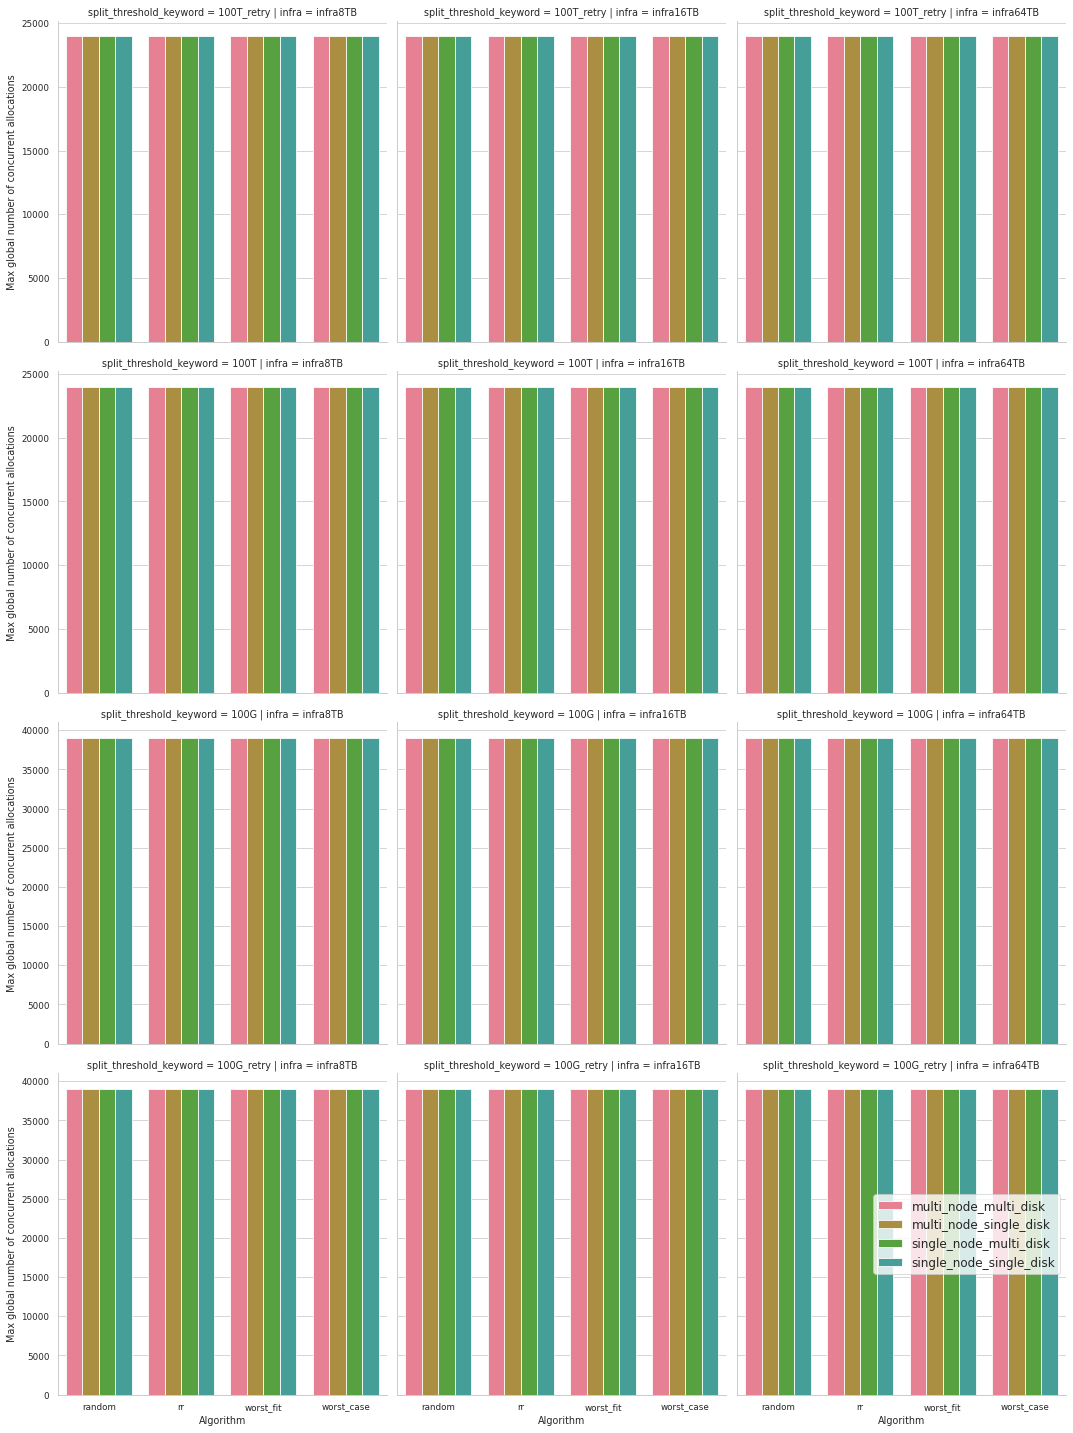

In [145]:
sns.set_theme(**categorical_theme_2)

# --- REQUEST COUNT (total number of requests processed by scheduler, 
# even those which were delayed, split, or resulted in fallback to the main PFS)
# Should be the same number for all simulation which share the same split threshold setting.

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="requests_count", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row", 
    legend=False
)
g.set(ylabel="Max global number of concurrent allocations", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

# Define datasets with only the 100G split setting or only the 100T split settint (=> no split)
df_data_split_100G =   df_data.loc[(df_data.loc[:,"split_threshold_keyword"] == "100G") | (df_data.loc[:,"split_threshold_keyword"] == "100G_retry")].copy()
df_data_no_split = df_data.loc[(df_data["split_threshold_keyword"] == "100T_retry") | (df_data["split_threshold_keyword"] == "100T")].copy()

max_res_count_split = df_data_split_100G["requests_count"].max()
max_res_count_no_split = df_data_no_split["requests_count"].max()

print(f"Max number of requests for simulations with no split : {max_res_count_no_split}")
print(f"Max number of requests for simulations with split : {max_res_count_split}")
print(f"Using splits increase requests count by {max_res_count_no_split * 100 / max_res_count_split:.2f} % ")

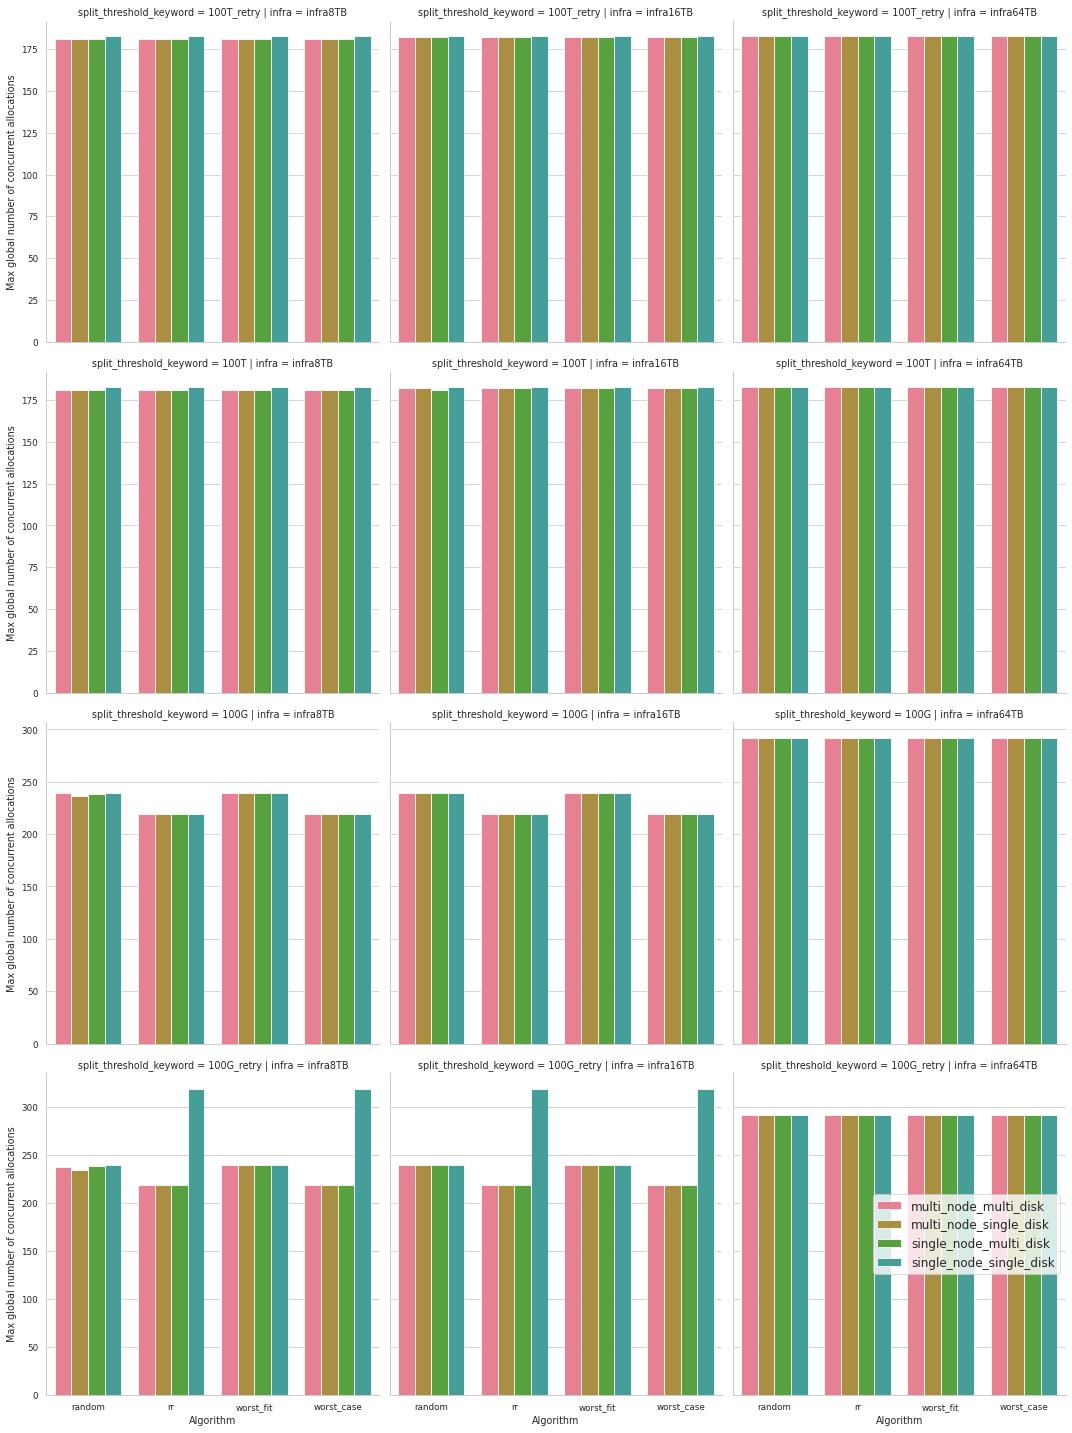

In [7]:
sns.set_theme(**categorical_theme_2)

# --- MAX CONCURRENT ALLOCATIONS (ALL NODES) (--> the maximum value for the total number of allocated requests, at any time, on any node / disk)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_concurrent_allocations", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Max global number of concurrent allocations", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")


Observations for max global number of concurrent allocations:

- When the split threshold is lower (100GB), we always get more concurrently allocated requests. Expected because for a lower threshold, 
  we have more split requests, so we have more requests in total. Also, each split request is smaller than the original one, and thus easier to allocate, even on
  smaller disks.
- When threshold for split is set to 100TB (almost no split), allowing for retries at a later time or not seems to have no effect at all.
  This is expected because
- On the contrary, with a smaller split size of 100GB, we can see an improvement for the single node / single disk architecture. 
  This is expected as the only solution for possibly having more concurrent requests allocated on a single element is to wait for some previous big 
  requests to terminate, and thus get some free space for (maybe) more smaller requests. On the other architectures, retries won't help much as any 
  big request will impact only one disk in one node, and other smaller requests may be allocated to other disks anyway.
- When the split threshold is at 100TB, we get almost the same result for all algorithms, all infrastructures, and with or without retries. 
  This is linked to a particular artifact in our dataset : a benchmark over a few days, with tens of allocations per days (up to ~175), with very small 
  storage needs (a few MB ? (needs verification)). These requests can be allocated with any infra / algo / retry behaviour because they are so small. 
- Obvious point, but worth remembering: having more requests allocated for the 100GB threshold and the 100TB threshold doesn't not necessarily mean that more GB
  could be allocated at 100GB split threshold.

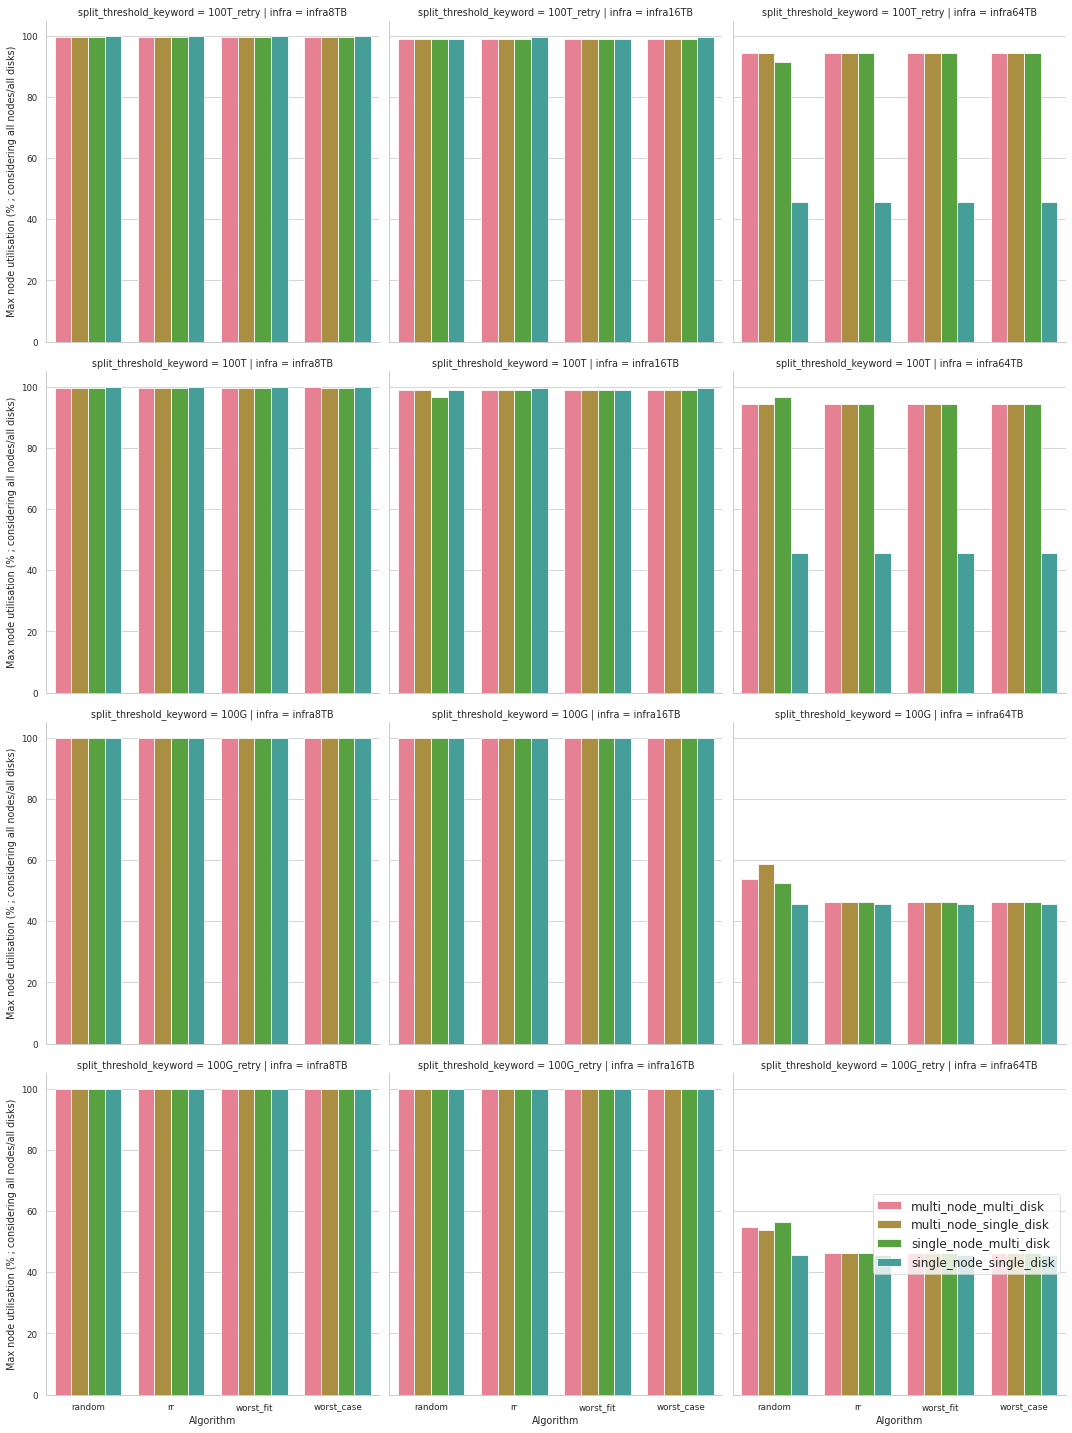

In [8]:
sns.set_theme(**categorical_theme_2)

# --- MAX NODE UTILISATION (ALL NODES)
# For platform with underfit capacity (8/16 TB), every algorithm reaches about 100% max node utilisation (see above how this is computed) : 
# it means at least 1 disk per node has reached 100% utilisation

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_utilisation", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Max node utilisation (% ; considering all nodes/all disks)", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

Observations for max node utilisation:

- Retry vs no-retry strategies have once again not much effect, in particular for the 100T split threshold
- The split threshold has two noticeable effects :
    - With total capacities of 8TB and 16TB we systematically reach a 100% max node utilisation for 100GB split, whereas for 100TB, 
      we usually fall short of full utilisation by a few %. This is not surprising as smaller requests are easier to schedule AND even better:
      when we split à 100GB, we get many requests whose size is exactly 100GB. WIth enough of these, you can easily reach exactly 100% utilisation on a "small"
      disk (1TB / 2TB)
    - For a total capacity of 64TB, we observe the opposite behaviour: at 100TB split, the max node utilisation is higher than at 100GB split.
      - 100TB split actually means almost no split (or even if there was any split, the new requests capacity would be 100TB, still impossible to fit on any of 
        our disks), so big requests (many hundred of GBs) are expected to be allocated. Also, chances are most of them won't 
        be a round number (requested capacity is based on data usage from an application, not a neat, round number provided by a human user).
      - We could hope for a lucky set of requests totalling almost the size of a disk, thus reaching 100% max utilisation or so, but the results 
        we observe here show that no matter the retry strategy or the algorithm in use, we always get the same max node utilisation for 100TB split.
      - This tends to indicate that a single requests is responsible for the observe max node utilisation. If so, it should have a capacity of slightly more 
        than 90% of 8TB. And indeed, looking in the dataset, we can see that the biggest requested capacity under 8TB is at 7.317 TB, which roughly represents
        92% of the 8TB disk.
      - On the other hand, for 100GB split, the same request would be split in 73 or 74 requests (internal threshold), and would be shared on as many disks as
        possible. 
      - Finally, the largest requested capacity is at ~ 16TB. We could only try to allocate it when split threshold is at 100GB. In that case, we would end 
        up with ~ 164 requests -> the 64TB infrastructure has up to 8 disks -> that's about 20 requests per disk (2TB per disk) -> represents only 25% of 
        disk capacity. There are 'only' 38 requests with capacity > 8TB, in a dataset of 24000 requests, the other requests being much smaller (the 100th largest
        request is "only" 2.2TB). It is then indeed quite/statistically unlikely that many very large requests are allocated at the same time, and we indeed see 
        that for 100GB split threshold, we peak at 60% max node utilisation.
- For splits at 100GB, the retry strategy has some limited impact with the random algorithm... why ? (not sure if this matters a lot anyway)


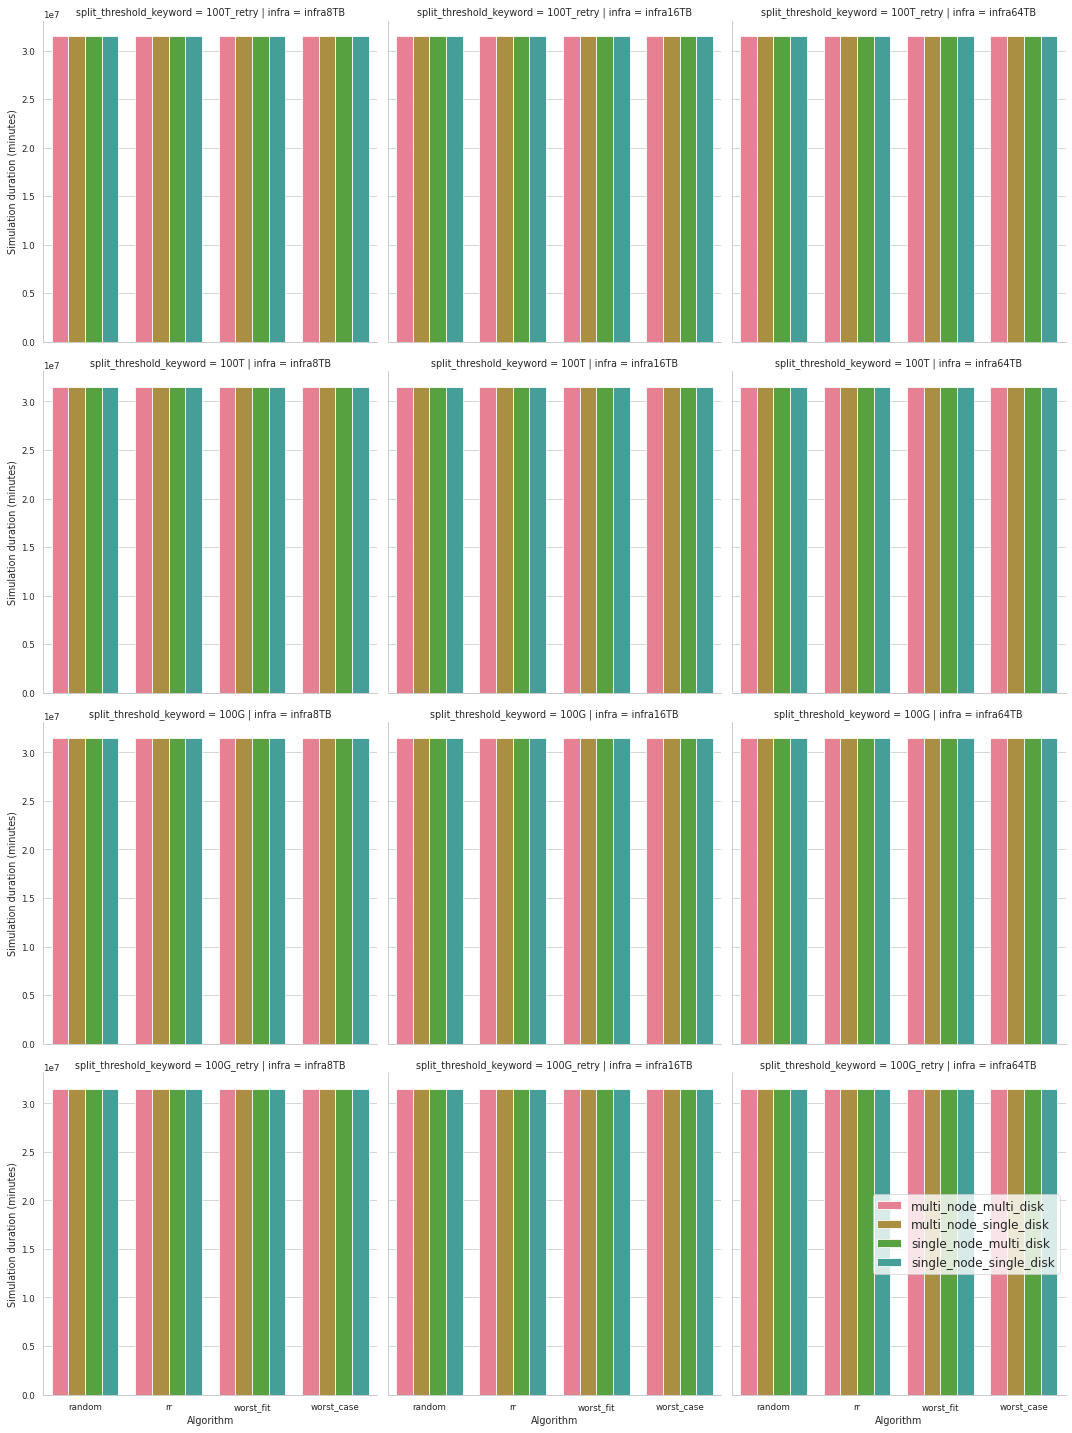

In [9]:
sns.set_theme(**categorical_theme_2)

# --- SIMULATION DURATION (ALL NODES)
# For every experiments, the entire dataset has been processed (no algorithm failed/crashed early)
# Values must all be the same at slightly above 3e7 minutes, unless simulations have crashed before reaching the end of the dataset.

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="sim_duration", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Simulation duration (minutes)", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

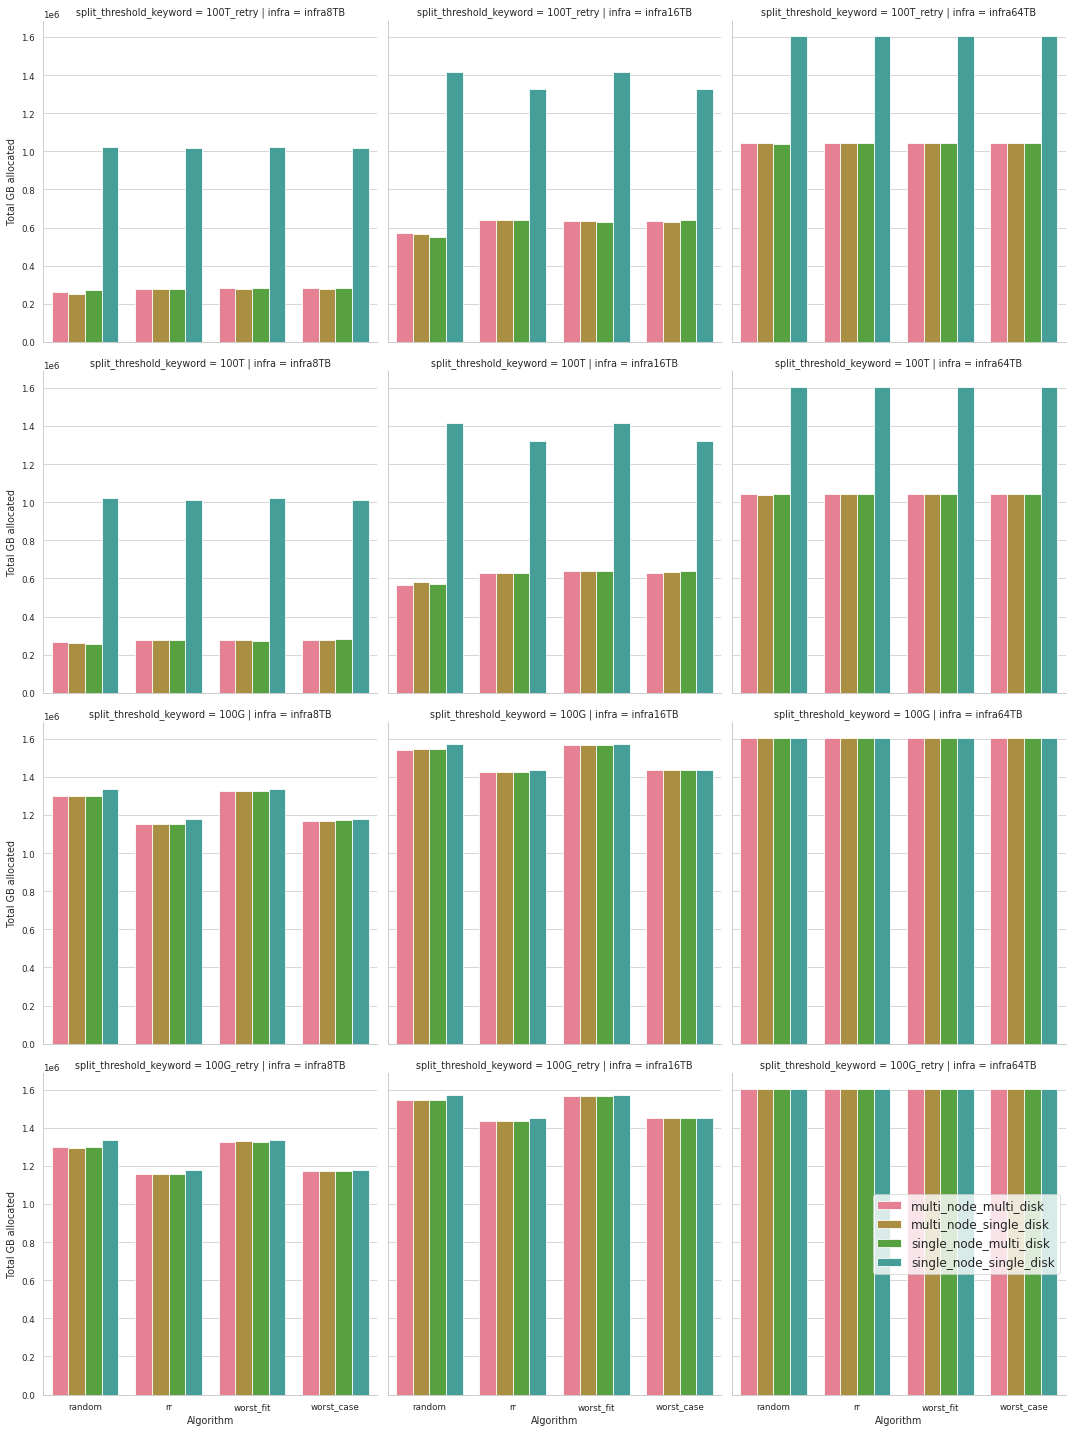

In [10]:
sns.set_theme(**categorical_theme_2)

# --- TOTAL GB ALLOCATED (ALL NODES)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_allocated_gb", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Total GB allocated", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

Observations on total allocated number of GB:

- The maximum we can reach for any parameter combination seems to be slightly below 1.2e6 GB
- Using a high threshold for split (100TB), that prevents any request from being split, results in a much lower total allocated volume for almost all infrastructures, except when using a single node / single disk setup with 64TB capacity.
  - In this later case, we see that the difference (if any), is barely noticeable on the 64TB infrastructure. As explained earlier, this is mainly due by the     fact that strictly no requests capacity is larger than 16TB in our dataset, and for this infra, the single disk in use has a capacity of 64TB (and we know from the previous graph that these 64TB disks are never used at more than ~ 45% of their total capacity, so every requests could be allocated).
- Single Node / single Disk case for 16TB and 8TB infra : we know from previous graph that the max capacitTy is at 100% or almost 100% for these disks, and we also know that some requests are larger than 16TB and larger than 8TB, so they can't fit without split. This explains the difference in total allocated volume for these infra capacity, when comparing 100TB splits and 100GB splits.
- For all other architectures (1NND, NNND, NN1D), the reasoning is the same as above, but much more requests canno't fit without split as the disks are much smaller (1TB / 2TB)
- For a given split / retry strategy, we can already see that not all algorithms have the same performance, with worst_fit and random able to allocate more volume. We suspect their advantage lies in the fact that these two algorithms are the only one which takes into account the remaining free space on the disks before making a decision, or internally retry the node / disk selection process if they determine that the initial choice (which includes more or less randomness) was not suitable (worst_case does too actually but not as precisely / in the same fashion as worst_case for instance : at some point in the algorithm, it just chooses some candidate at random and return, even though the choice might not work at all).
    - As a side note, we can also determine that both 8TB and 16TB storage platform are either too small in capacity or offer too small disks, as none of the
      algorithm can reach the same allocated volume as what happens on the 64TB platform (although another explaination could be that all the algorithms are very
      bad, unless in run in optimal conditions ;))

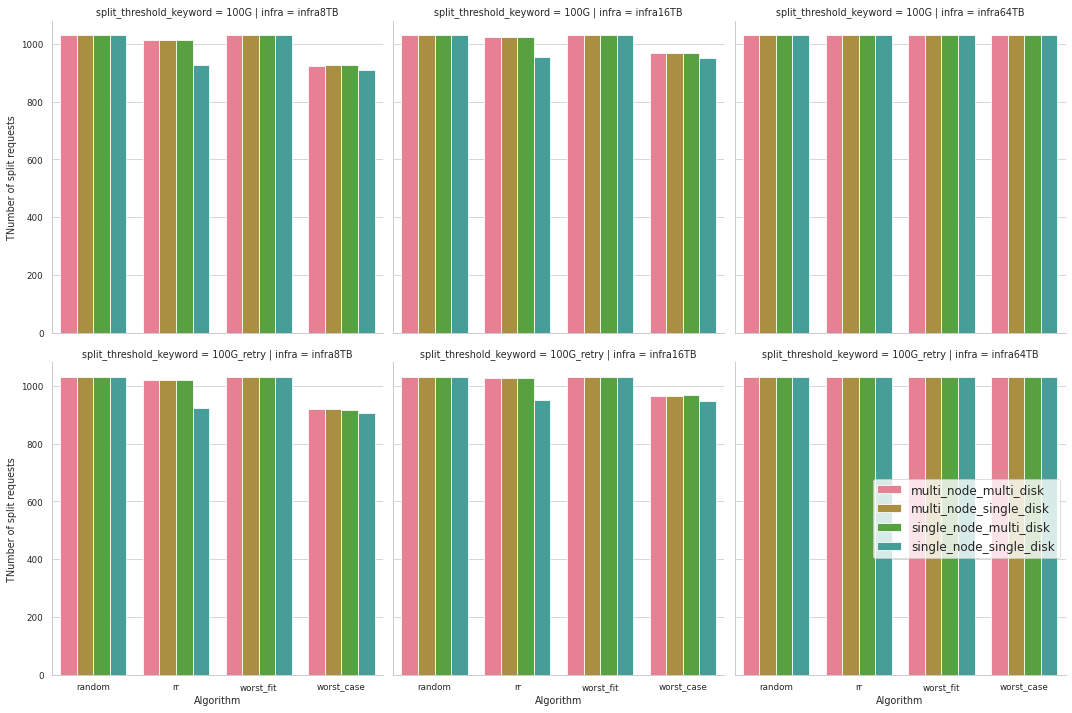

In [37]:
sns.set_theme(**categorical_theme_2)

# --- NUMBER OF SPLIT REQUESTS

g = sns.catplot(
    data=df_data_split_100G, kind="bar",
    x="algo", y="split_requests_count", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="TNumber of split requests", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

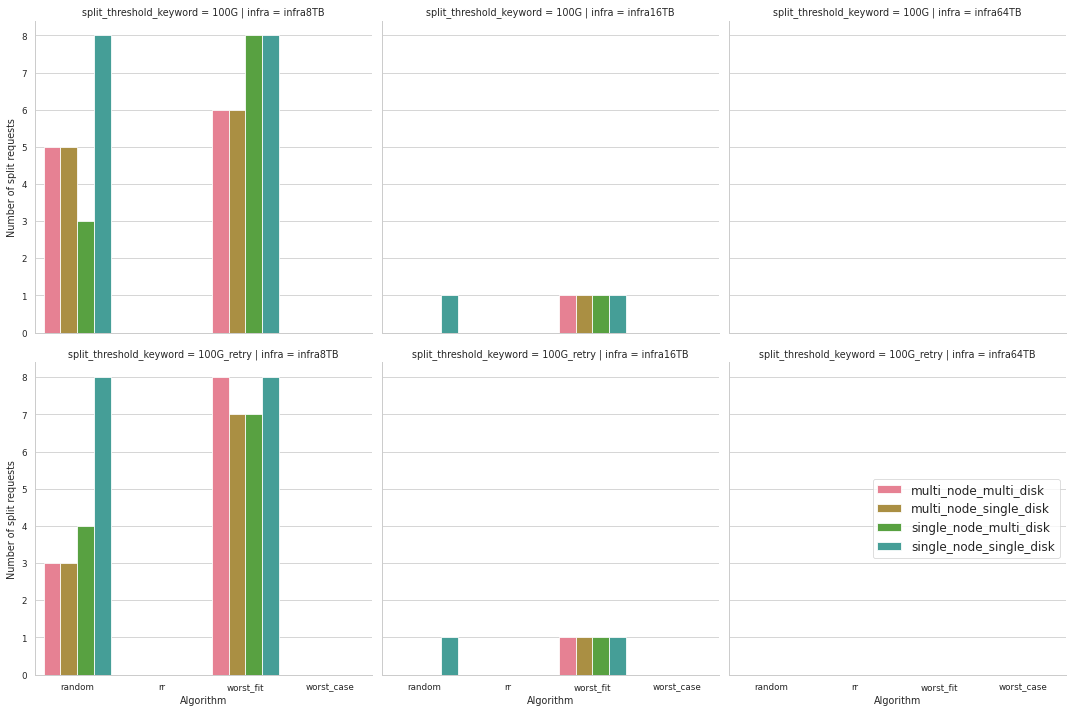

In [39]:
sns.set_theme(**categorical_theme_2)
 
# --- NUMBER OF NOT ALLOCATED SPLIT REQUESTS (REFUSED DURING SIMULATION, NOT BY SCHEDULER)


df_data_split_100G.loc[:, "not_alloc_splits_request_count"] = data_split100G.loc[:, "split_requests_count"] - data_split100G.loc[:, "alloc_split_requests_count"]

g = sns.catplot(
    data=df_data_split_100G, kind="bar",
    x="algo", y="not_alloc_splits_request_count", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, 
    legend=False,
)
g.set(ylabel="Number of split requests", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

Observations (NUMBER OF SPLIT REQUEST):

- We plot only for 100G splits, as there are no splits if threshold is set to 100T
- We can see that the number of split requests is the same for all algorithms when running on a 64TB platform (which isn't constraint in term of capacity with our current dataset). About 650 requests are above the 100G threshold and thus need to be split.
- For 8TB and 16TB we observe two trends :
    - Depending on the algorithm, the 8TB storage infra has as many split requests recorded or less, but never more. We can assume this is linked to the fact that our dataset contains 38 requests which are larger than 8TB, and thus have no chance to fit, even when split, on this infra. The same happens for 16TB infra, but for a handful of requests only. Also, any large request (1TB < c < 8TB), even when split, will take a noticeable amount of space on the disks. For instance, on the 8TB infra, the smaller disks are 1TB, so any 100GB partition of a TB request will take 1/10th of the capacity of a disk. Hence it is not suprising that sometimes the disks get full and requests that were split still have to be dropped in the end.
    - Some algorithms still use ~650 split requests (random, worst_fit, rr most of the time) when others do no, (rr for 1N1D, worst_case). Possible explanations:
        - maybe worst_case does a worse job than the other for more/smaller requests (it is indeed in the low end of allocated volume, when split is used, and has comparable performance when split is not used). This could be due to the fact that worst_case tries to select a server/node/disk tuple using the available bandwidth as the main parameter, and doesn't make much assumptions on the remaining free storage. Other algorithms either select a disk based on its utilisation or are implemented with basic internal retry mechanisms (for instance round robin tries to select a disk in a round robin fashion, but will retry up to five times if it think the next disk in line clearly doesn't have enough space based on current allocations). So maybe worst_case has more chances to allocate a part of a split requests on a node that actually doesn't have the capacity ?
        - For round robin, we can see that only the 1N1D infra doesn't reach the ~650 split requests milestone... that's probably because rr, as opposed to random for instance, may return a negative answer because it determines that there won't be enough space 
        
Observations (NUMBER OF UNALLOCATED SPLIT REQUEST):

This plot is just there to show that the phenomenon is marginal : among requests that have been split (~1000), only up to 8 in the worst case end up not being allocated.
We could argue that the split strategy results in few drawbacks, but maybe this low fall back rate could also be linked to an unknown trend in the way job are deployed (when a request is split, it means the job needed more than 100GB of data -> it is possible that jobs which use "so much" data are also quite computational intensive, and thus use quite a lot of compute resources, so maybe not many of them run at the same time -> the bigger the requests, the less likely the storage has to deal with many other similar requests at the same time. That's purely hypothetical, but we could investigate. And anyway, it's probably only true for this very specific dataset)

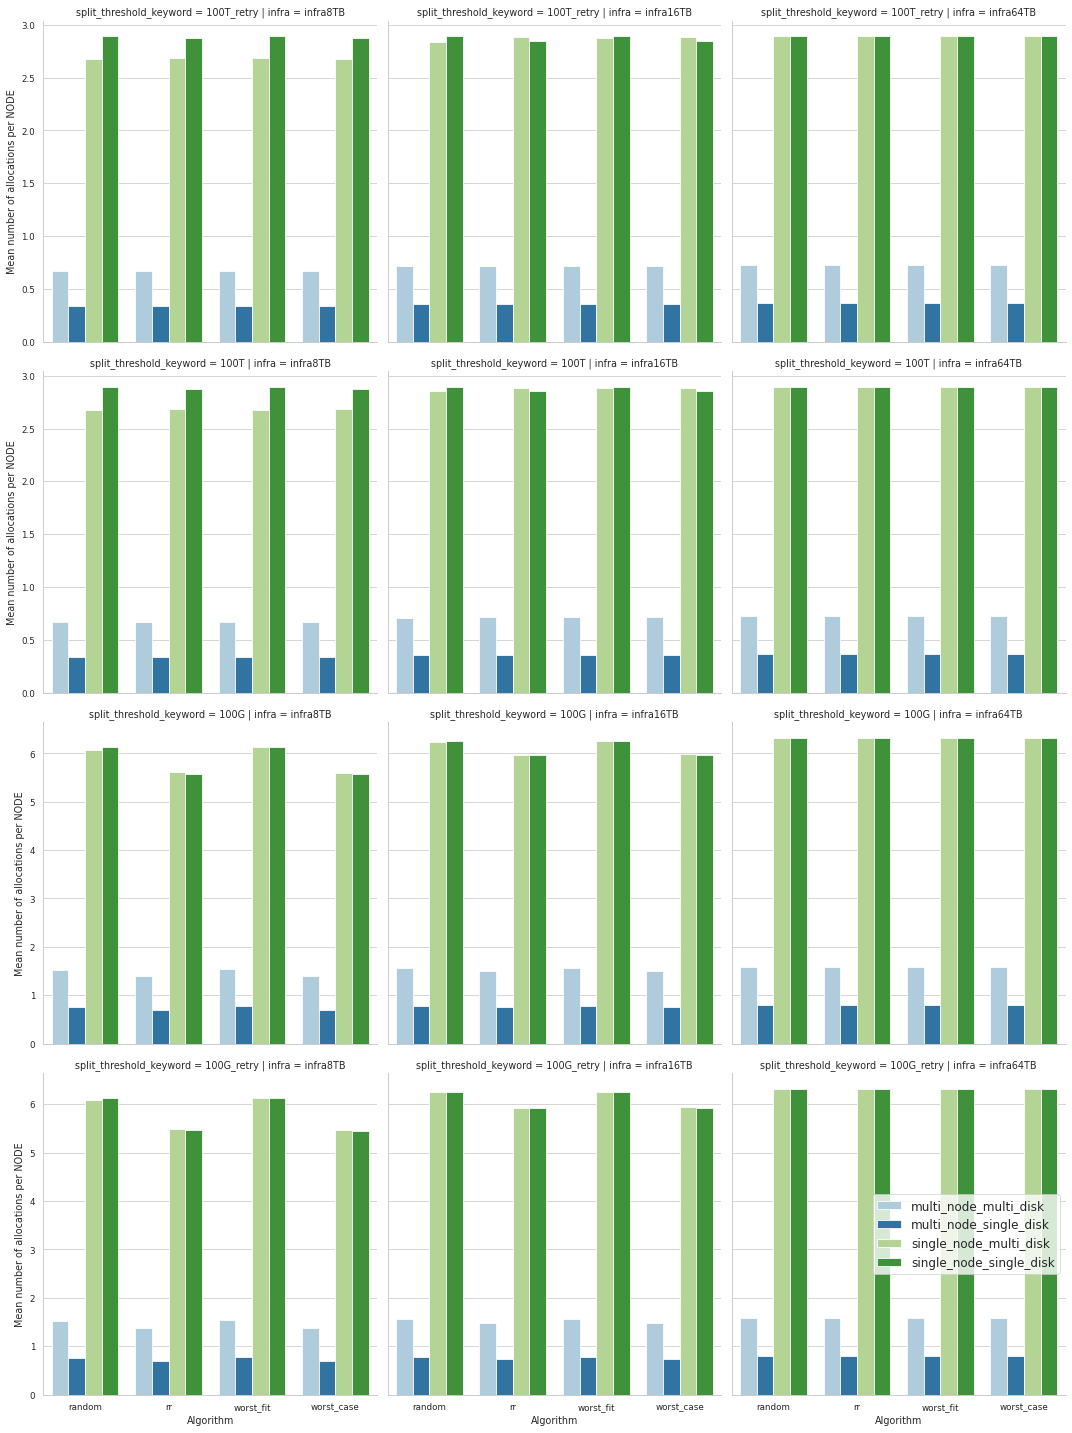

In [13]:
# [1] --- Mean number of allocations per node, for every algorithm
# -> IF it's correct, it correspond to the mean number of allocation over the entire dataset period 
# Computed in the following way : if a disk has 1 allocation during 5s, and the dataset duration is 10s in total, then over the dataset duration period, this
# disk has (5s*1a + 5s*0a) / 10s) = 0.5. Our standard dataset is very sparse (there can be only a handful of allocations per day, lasting for as short 
# as a few minutes, and the dataset covers a whole year... so the means are quite low)

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="mean_node_alloc", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Mean number of allocations per NODE", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

Observations:

- Single node infras (green) have a higher mean number of allocation per node than multi node infras (blue). What a surprise (but at least it's coherent).
- At the node level, mean number of allocation variations are very small from one "split threshold + infra size" setup to another. They are more noticeable for single node setups. Why ?
- On average, values are really low (with 100T split threshold, none are above 1 for multi node infras) This is because we calculate the mean over the entire period of time in our dataset, not only during times when there's at least one allocation somewhere on the storage system. And the dataset is not really dense (large periods of time have 0 allocations). Unsurprisingly, the mean is much higher when using a low split threshold, which results in much more requests over the simulation period 

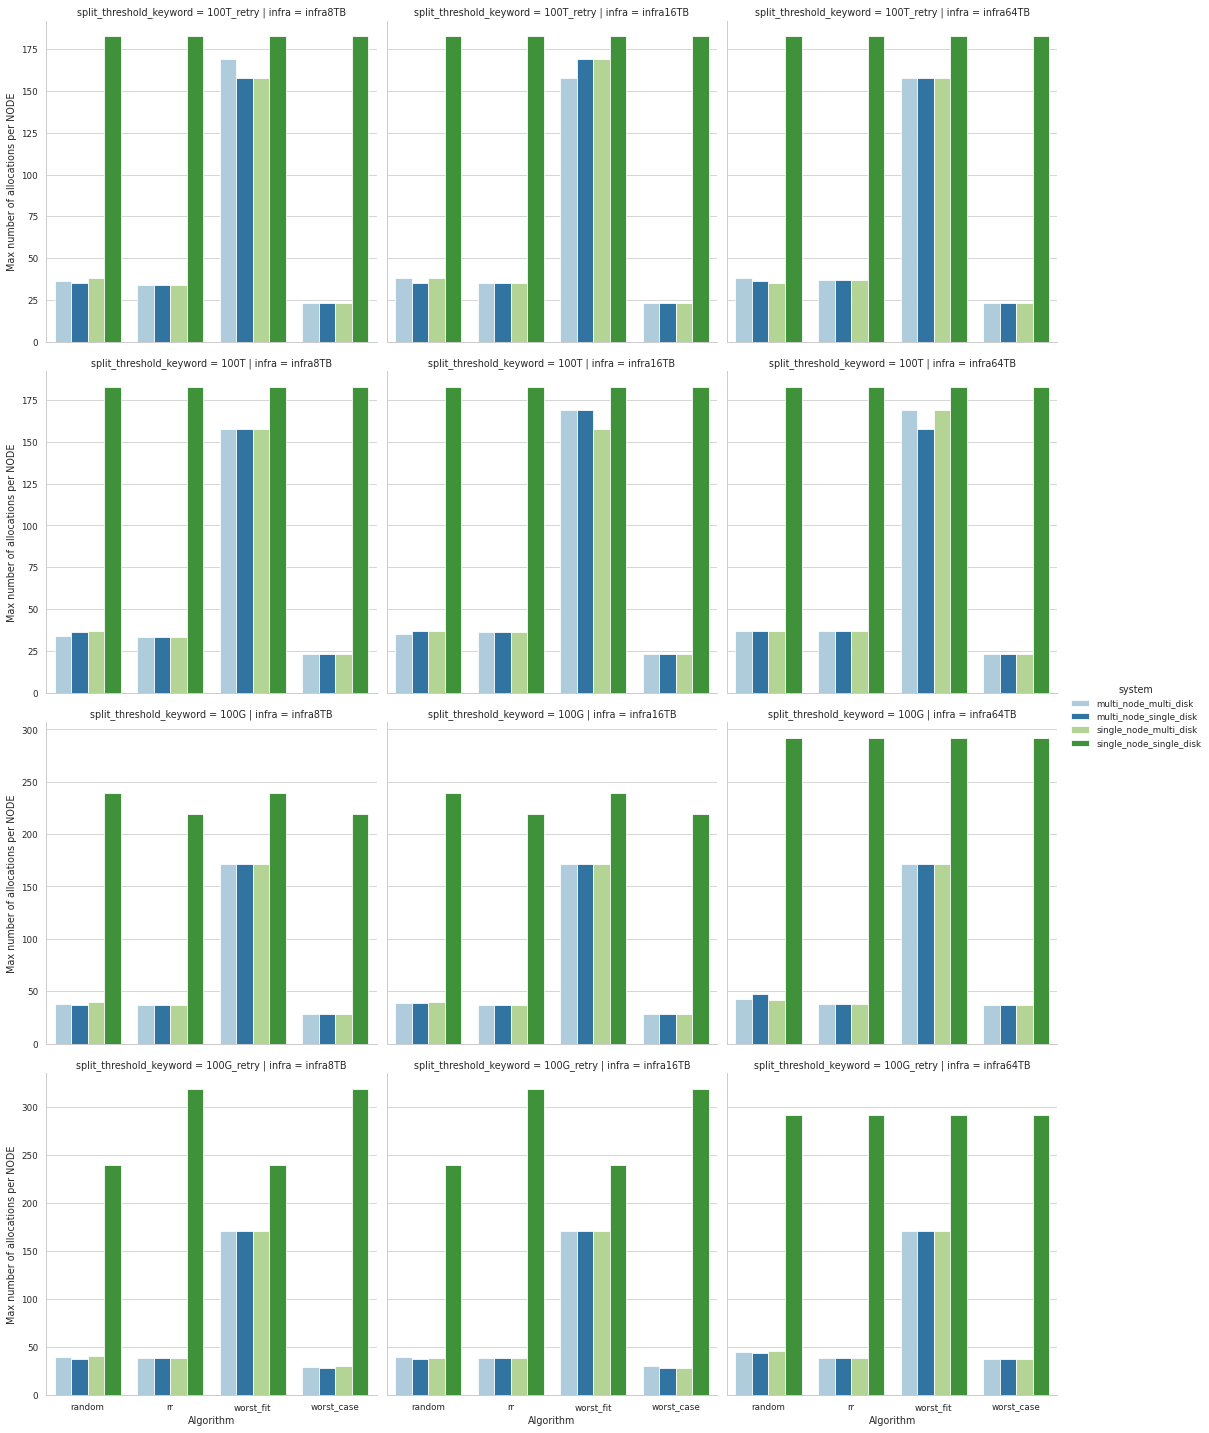

In [45]:
# [2] ---  Max number of allocations per node, for every algo (main parameters of the simulation are in its name)
# Corresponds to the max number of allocations for any single disk in the node. It can go very high because our dataset contains a period of 
# benchmarks around december 4th-7th, with huge number of very small and very short allocations each day.
# Worst_fit tends to have very high number of allocations for every kind of system, as it is its goal to always put allocations on the disk that already has
# the most.

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_alloc", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order, sharey="row",
    height=5
)
g.set(ylabel="Max number of allocations per NODE", xlabel="Algorithm")

Observations:

Two main outliers:

- every 'single_node_single_disk' archi, compared to the others: That's normal, this metrics corresponds to the max number of allocations on any single disk of a node. All other archi have either multiple nodes or multiple disks to load balance the requests, this one only ever offer a single choice of storage resource. Variations may only happen between simulations if the capacity of this disk is too small and when algorithms adress the issue differently. In that regard:
  - without split, we observe no variation of the max allocation number, in all 24 simulations. That's because at some point in the dataset (~ december), there's a period of several days during which we reach this maximum with only very small allocations (no more than a few MB), garanteed to fit on this single disk. On the other hand, because there's no split allowed, no huge request (8-16 TB ?) can impact the maximum by being split, if it fits.
  - with split, we see variations between (8TB, 16TB) infra and 64TB infra (the already mentionned requests that are > 8TB and > 16TB, and can't fit, even when split + the additional load from all the 100GB+ requests, split and allocated, or not, depending on how good the algorithm is at dealing with more requests). **However**, with retry allowed, we also observe that round robin and worst_case fit a greater maximum number of allocations on the 8/16TB infra than on the 64TB infra... This is odd. Maybe due to some large request not fitting at a given point (due to disk size), but then allowing for many smaller requests right after ?
- every use of the 'worst_fit' algorithm results in higher maximum. That's also normal because this is exaclty worst_fit intended use case : choose to allocate requests on the disks that already have the most request, as long as new requests fit. So it's normal to see a behaviour similar to the one displayed with 1-node-1-disk infra, although the maximum is lower because disks are smaller in other infra, and can fit less requests.

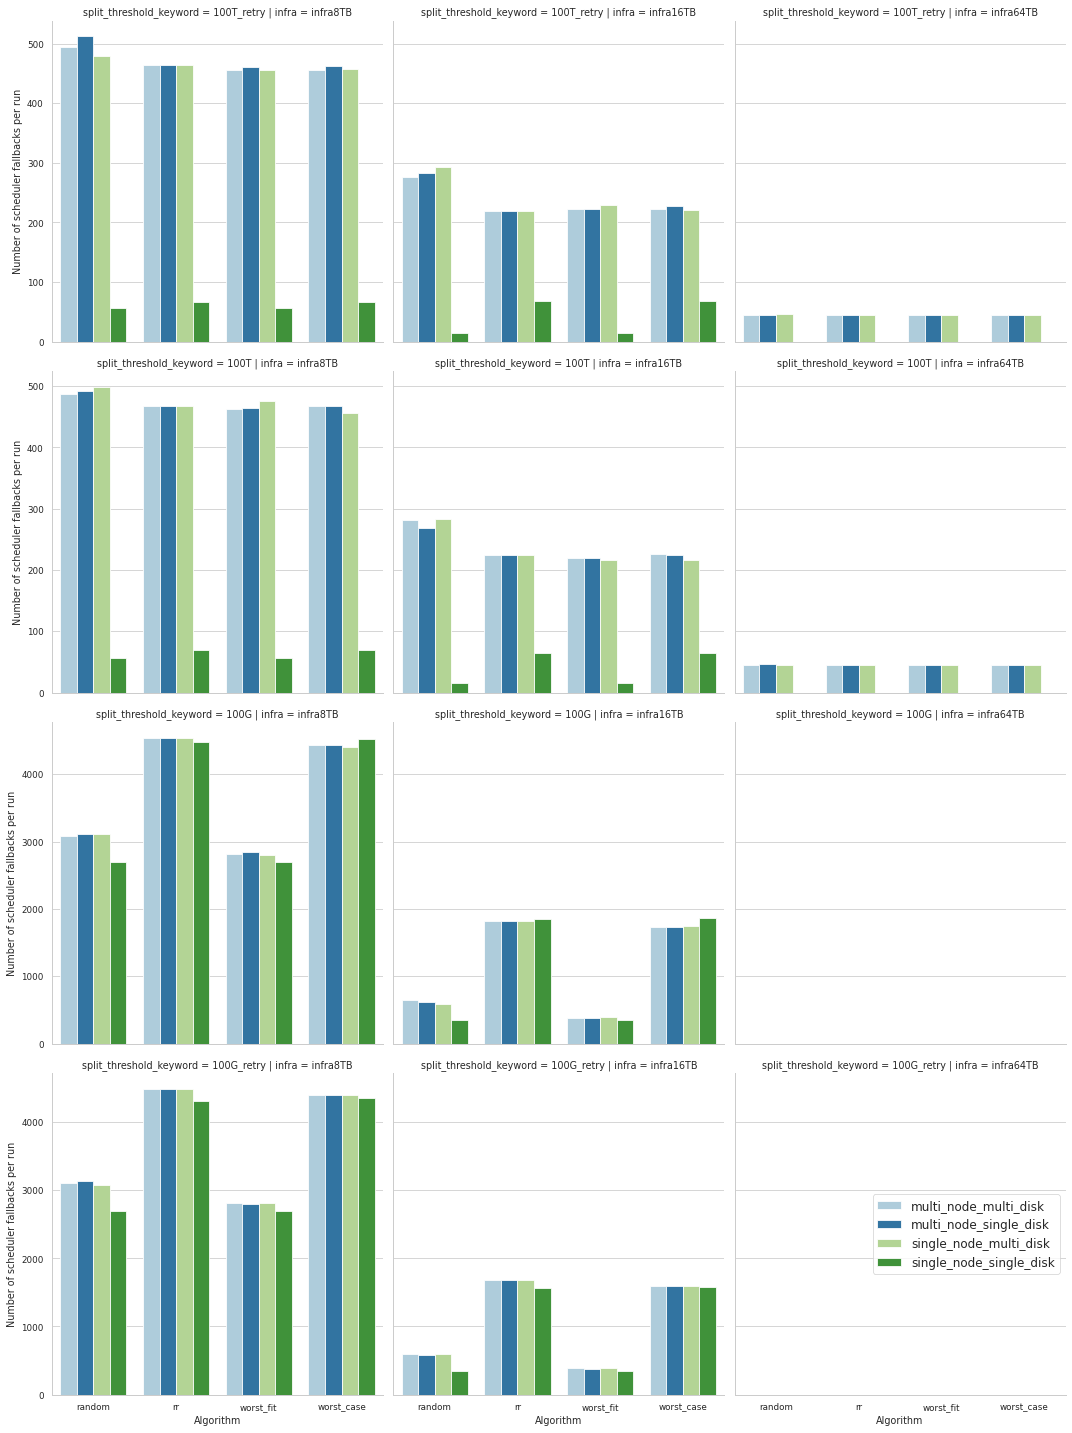

In [57]:
# [3] ---  Total number of scheduler fallbacks, for every simulation
# Failures are of course dependent on the total capacity of the system. 

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="scheduler_fallbacks_count", hue="system", col="infra", row="split_threshold_keyword",
    col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of scheduler fallbacks per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

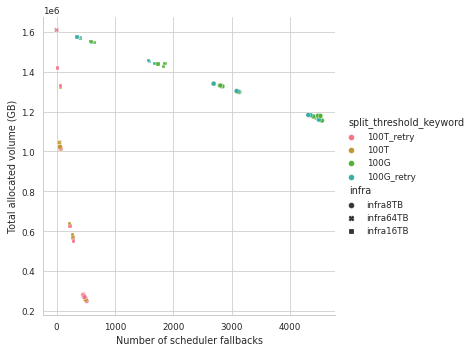

In [155]:
sns.set_theme(**categorical_theme_2)

g = sns.relplot(
    data=df_data,
    kind="scatter",
    x="scheduler_fallbacks_count", 
    y="tt_allocated_gb",
    hue="split_threshold_keyword",
    #size="tt_delay_time_minutes",
    style="infra",
    # col="",
    # col_order=infra_order, 
    # order=algo_order, 
    # sharey="row",
    height=5, 
    legend=True
)
g.set(ylabel="Total allocated volume (GB)", xlabel="Number of scheduler fallbacks")


Observations:

**Reminder: a 'fallback' occurs when StorAlloc scheduler returns a negative answer OR when it has returned a positive answer, but it then happens to be a bad decision that can't be applied to storage when running the sim.**

- In general, the bigger the disks / the larger the total capacity, the less fallbacks happen. Quite coherent.
- The amount of fallback is much higher when using split : it's "normal", every split request that eventually can't make it will result in more fallbacks (one for each sub requests). 
- Round Robin and Worst case seem definitely lead to more fallback in the split scenario. THis may be due to the fact that these algorithms have internal mecanisms that make them more likely to refuse a requests, and the number of requests may amplily this effect 

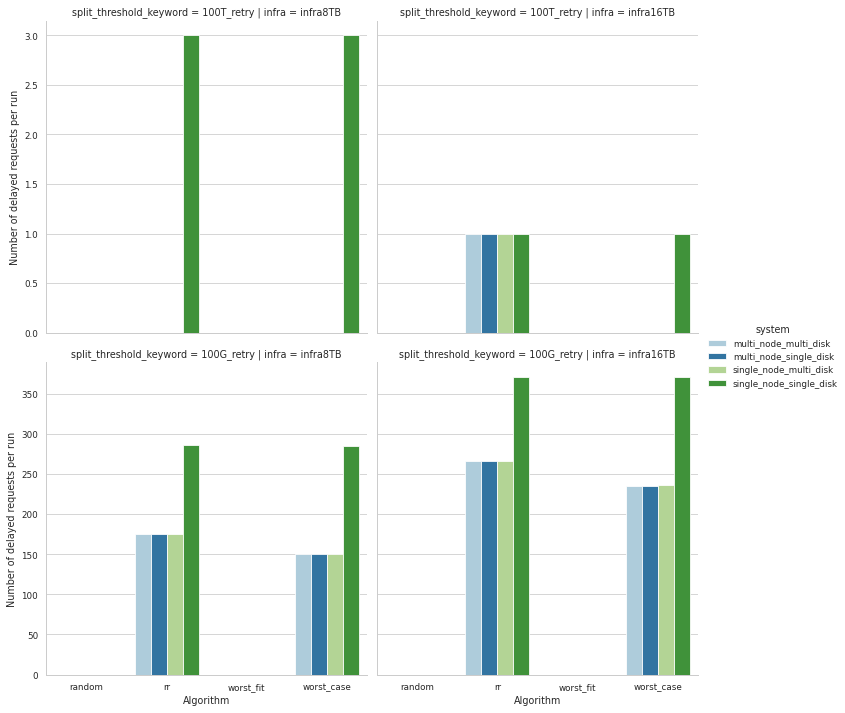

In [128]:
# [4] ---  Total number of delayed requests, for every simulation 
# (to be confirmed) only rr and worst_case are able to alert the scheduler that they didn't find a suitable choice, which allows for a retry with delayed 
# start_time. We see that worst_case is more prone to trigger retries with delays, but it also usually suffers from less failures than rr (as per previous graph)
# We might think that worst_case does a better job at knowing when a request won't be able to be allocated, and as per plot "TOTAL GB ALLOCATED (ALL NODES)",
# we can see more GB in total are allocated when using worst_case than when using rr

sns.set_theme(**categorical_theme)

df_data_retry =   df_data.loc[(df_data.loc[:,"split_threshold_keyword"] == "100G_retry") | (df_data.loc[:,"split_threshold_keyword"] == "100T_retry")].copy()
df_data_no_retry = df_data.loc[(df_data["split_threshold_keyword"] == "100G") | (df_data["split_threshold_keyword"] == "100T")].copy()


g = sns.catplot(
    data=df_data_retry,
    kind="bar",
    x="algo", 
    y="delayed_requests_count",
    hue="system",
    col="infra",
    row="split_threshold_keyword",
    col_order=infra_order[:2], # all value == 0 for infra 64TB
    order=algo_order, 
    sharey="row",
    height=5, 
    legend=True
)
g.set(ylabel="Number of delayed requests per run", xlabel="Algorithm")
#plt.legend(fontsize="12", loc="best")

Observations:

- only rr and worst_case generate retries (other algorithms will return a "valid" answer everytime, so the retry mechanism in the scheduler won't be triggered.
- no retries for 64GB infra. Seems legit as this infra is slightly overprovisionned in terms of capacity

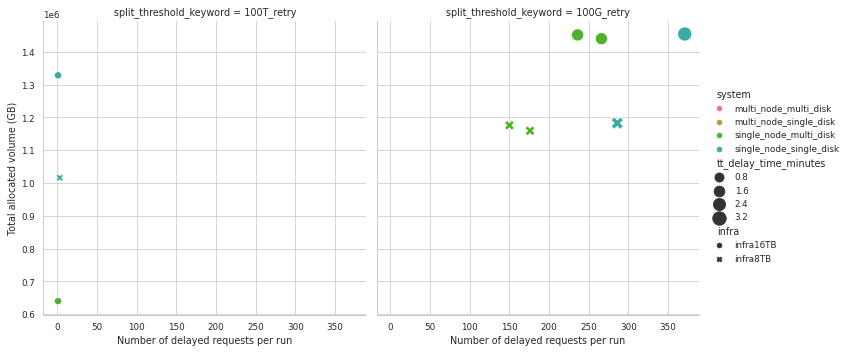

In [101]:
# [4BIS] ---  Total number of delayed requests, compared to allocated GB, 
# with dot size pondered by total waiting time in minutes

sns.set_theme(**categorical_theme_2)

g = sns.relplot(
    data=df_data_retry[df_data_retry["delayed_requests_count"] > 0],
    kind="scatter",
    x="delayed_requests_count", 
    y="tt_allocated_gb",
    hue="system",
    size="tt_delay_time_minutes",
    style="infra",
    col="split_threshold_keyword",
    # col_order=infra_order, 
    # order=algo_order, 
    # sharey="row",
    sizes=(50,200),
    height=5, 
    legend=True
)
g.set(ylabel="Total allocated volume (GB)", xlabel="Number of delayed requests per run")


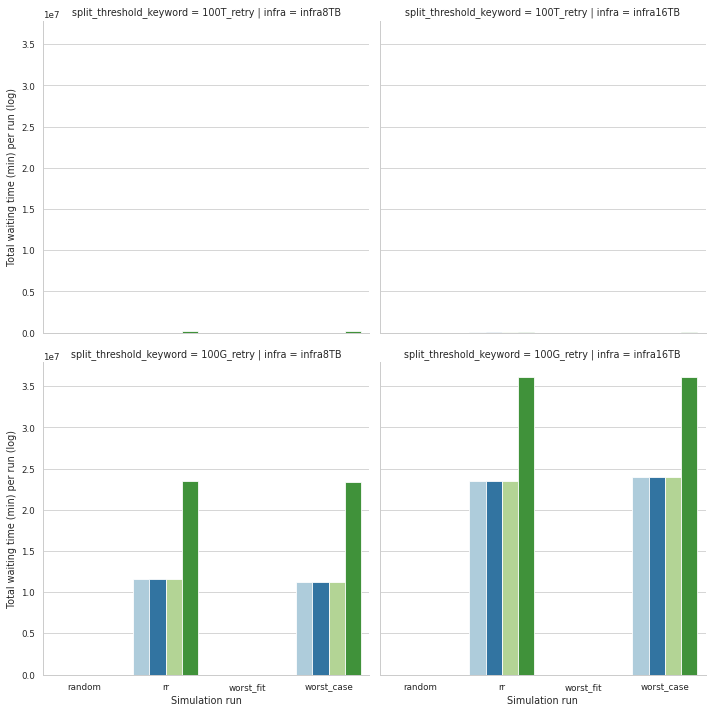

In [123]:
# [5] ---  Total cumulated waiting time for delayed requests, for every simulation
sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data_retry[(df_data_retry["delayed_requests_count"] > 0)], 
    kind="bar",
    x="algo", 
    y="tt_delay_time_minutes", 
    hue="system", 
    col="infra",
    row="split_threshold_keyword",
    col_order=infra_order[:2],    # All values = 0 for 64TB infra
    order=algo_order, # sharey=False,
    height=5, legend=False
)
# g.set(yscale="log")
g.set(ylabel="Total waiting time (min) per run (log)", xlabel="Simulation run")
#plt.legend(fontsize="12", loc="right")

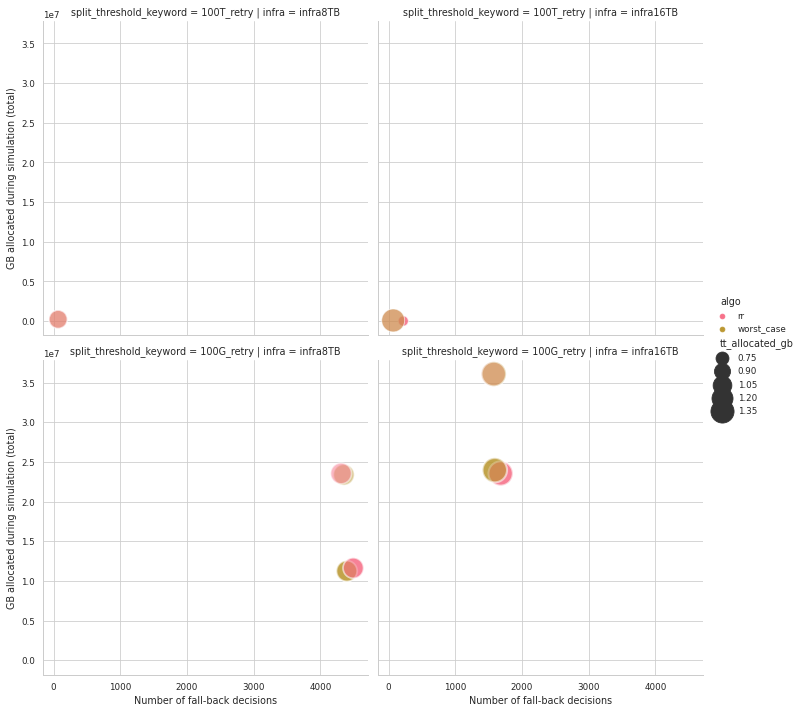

In [139]:
# # --- TOTAL GB ALLOCATED (ALL NODES) VS Scheduler fall-back 
# Suprisingly, the more scheduler failures, the less GB could be allocated ....
# More "interesting" findings:
# - configurations with high number of delayed requests are found both for "small" and "high" 
#   number of fall-back decision (actual number depends on the infra capacity) --> delaying requests 
#   for up to one hour doesn't seem to achieve better allocation results. We observe the same when considering 
#   total cumulated waiting time for delayed requests
# - the random algorithm (which doesn't permit delaying request because it always provides a 
#   seemingly valid server/node/disk tuple) clearly leads to most of the worst results


#sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_2)

g = sns.relplot(
    data=df_data_retry[(df_data_retry["delayed_requests_count"] > 0)],
    x="scheduler_fallbacks_count", 
    y="tt_delay_time_minutes", 
    hue="algo", 
    size="tt_allocated_gb",
    #size="tt_waiting_time_minutes",
    # style="system",
    col="infra",
    row="split_threshold_keyword",
    col_order=infra_order[:2],
    sizes=(100, 600), 
    alpha=.50,
    height=5, 
)
g.set(
    xlabel="Number of fall-back decisions", 
    ylabel="GB allocated during simulation (total)"
)

In [ ]:
# # --- TOTAL GB ALLOCATED (ALL NODES) VS WAITING TIME DURING RETRIES

#sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_2)

#sns.set_style("whitegrid")
g = sns.relplot(
    x="nb_of_delayed_requests", 
    y="tt_delay_time_minutes", 
    hue="algo", 
    size="tt_allocated_gb",
    # style="system",
    col="infra",
    row="split_threshold_keyword",
    col_order=infra_order,
    sizes=(100, 600), 
    alpha=.30,
    height=5, 
    data=df_data
)
g.set(
    xlabel="Number of  delayed requests", 
    ylabel="GB allocated during simulation (total)"
)

In [ ]:
# [6] ---  Create a second dataset where each row is a disk (instead of having one simulation per row)

data_by_disk = {
    "run_name": [],
    "node_id": [],
    "disk_id": [],
    "full_disk_id": [],
    "disk_mean_nb_alloc": [],
    "disk_max_nb_alloc": [],
    "disk_mean_cap_percent": [],
    "disk_max_cap_percent": [],
    "disk_capacity": [],
    "infra": [],
    "system": [],
    "algo": []
}

for idx, row in df_data.iterrows():
    for node in row['nodes']:
        for disk in node["disks"]:
            data_by_disk["run_name"].append(row['full_name'])
            data_by_disk["node_id"].append(node['id'])
            data_by_disk["disk_id"].append(disk['id'])
            data_by_disk["full_disk_id"].append(f"{node['id']}:{disk['id']}")
            data_by_disk["disk_mean_nb_alloc"].append(disk['mean_nb_alloc'])
            data_by_disk["disk_max_nb_alloc"].append(disk['max_alloc'])
            data_by_disk["disk_mean_cap_percent"].append(disk['mean_capacity_utilisation'])
            data_by_disk["disk_max_cap_percent"].append(disk['max_cap_utilisation'])
            data_by_disk["disk_capacity"].append(disk['capacity'])
            data_by_disk["infra"].append(row['infra'])
            data_by_disk["system"].append(row['system'])
            data_by_disk["algo"].append(row['algo'])
    
data_by_disk = pd.DataFrame(data_by_disk)
data_by_disk

In [ ]:
data_by_disk = data_by_disk.sort_values(["algo",], ascending=True)

In [ ]:
# [7] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip",
    y="algo", x="disk_mean_nb_alloc",hue="system", col="infra",
    height=8, jitter=0.2, col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Mean number of allocations per disk", "Algorithm")

In [ ]:
# [8] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

# sns.set(rc={'figure.figsize':(29.7,21)})
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_mean_nb_alloc", hue="system", 
    dodge=True, width=0.5,
)
#g.set(xscale="log")
g.set(ylabel="Simulation run", xlabel="Mean number of allocations per disk")

In [ ]:
# [9] ---  Mean number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2, order=algo_order
)
g.set(yscale="log")
g.set(ylabel="Mean nb. of allocations", xlabel="Scheduling algorithm")

In [ ]:
# [10] ---  Max number of allocations per disk, organised by simulation run and infrastructure (1/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip", col="infra",
    y="algo", x="disk_max_nb_alloc",hue="system",
    height=8, jitter=0.2,
    col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Max number of allocations per node", "Algorithm")

In [ ]:
# [11] ---  Max number of allocations per disk, organised by simulation run and infrastructure (2/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_max_nb_alloc", hue="system",
    dodge=True, width=0.5, saturation=0.9
)
g.set(ylabel="Algorithm", xlabel="Max number of allocations per node")

In [ ]:
# [12] ---  Max number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Max nb. of allocations", xlabel="Scheduling algorithm")

In [ ]:
# [13] ---  Mean capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Mean capacity utilisation", xlabel="Scheduling algorithm")

In [ ]:
# [14] --- Max capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Max capacity utilisation", xlabel="Scheduling algorithm")

In [ ]:
data_by_disk_mean_alloc = data_by_disk.sort_values(["disk_mean_nb_alloc",], ascending=True)

In [ ]:
# [15] --- Disk mean nb alloc per run, with hue on Node ID 

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk_mean_alloc,
    y="system", x="disk_mean_nb_alloc",size=8, jitter=0.2, alpha=0.75,
    dodge=True,
    hue="algo",
)
g.set(xscale="log")


# g.xaxis.grid(True, "minor", linewidth=.25)
#g = sns.catplot(x="disk_mean_nb_alloc", y="run_name",
#                hue="node_id",
#                data=data_by_disk_sorted, kind="swarm",
#                alpha=.6, height=21, aspect=29.7/21);

#g.set(xscale="log")
# g.xaxis.grid(True, "minor", linewidth=.25)

In [ ]:
# [16] --- Disk mean nb of alloc compared to disk mean capacity utilisation

sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_disk)

infra8_data = data_by_disk[data_by_disk['infra'] == "infra8TB"]

#sns.set_style("whitegrid")
g = sns.relplot(
    x="disk_mean_nb_alloc", 
    y="disk_mean_cap_percent", 
    hue="algo", 
    style="infra",
    size="disk_max_nb_alloc",
    sizes=(100, 400), 
    alpha=.50,
    height=5, 
    data=data_by_disk
)
g.set(
    xscale="log", 
    yscale="log", 
    xlabel="Mean nb. of allocations per disk", 
    ylabel="Mean % of capacity utilisation per disk"
)

In [ ]:
# [16] ---

sns.set_theme(style="ticks")

cmap = sns.hls_palette(n_colors=data_by_disk['algo'].nunique())

g = sns.jointplot(data=data_by_disk, x="disk_mean_nb_alloc", 
                  y="disk_mean_cap_percent", 
                  hue="algo", marker="+")
#g.set(
#    xscale="log", 
#    yscale="log", 
#    xlabel="Mean nb. of allocations per disk", 
#    ylabel="Mean % of capacity utilisation per disk"
#)